In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [2]:
ufo = pd.read_csv("./data/scrubbed.csv", low_memory=False)

# 1. cleaning the data

In [3]:
ufo.columns.values

array(['datetime', 'city', 'state', 'country', 'shape',
       'duration (seconds)', 'duration (hours/min)', 'comments',
       'date posted', 'latitude', 'longitude '], dtype=object)

###  the `datetime` feature
- this columns contains both '24:00' and '00:00' values but only 00:00 are relevant
- we are going to find the value '24:00' and replace them with the "00:00" value
- then we convert `str` type to `TimeStamp`

In [4]:
ufo['datetime']=ufo['datetime'].replace({'24:00':'00:00'}, regex=True)

In [5]:
ufo['datetime'] = pd.to_datetime(ufo['datetime'])

### the `duration (seconds)` column

**when trying to convert values in the column `duration (seconds)` to `float`, we encounter `ValueError`**

In [6]:
ufo['duration (seconds)'].astype(float)


ValueError: could not convert string to float: '0.5`'

**here we try to find what causes the error : **

In [7]:
typos = []

row = -1 
for el in ufo['duration (seconds)']:
    row += 1
    if type(el) == float:
        continue
    for char in el:
        if char.isnumeric() or char == ".":
            continue
        else:
            typos.append((row, el))
            break
typos

[(27822, '2`'), (35692, '8`'), (41201, '2631600  '), (58591, '0.5`')]

**there're just a few typos, let's correct them :**

In [8]:
correct = {27822: '2', 35692: '8', 41201: '2631600', 58591: '0.5'  }

In [9]:
for k, v in correct.items():
    ufo.loc[k, 'duration (seconds)'] = v

**and finally we convert the values in this column into `float' :**

In [10]:
ufo['duration_sec'] = ufo['duration (seconds)'].astype(float)

### `latitude and longitude` feature : 

**converting `latitude` values into `float` causes error :**

In [11]:
ufo['latitude'].astype(float)

ValueError: could not convert string to float: '33q.200088'

**trying to find what causes the exception :**

In [12]:
row = -1
container = []
for i in ufo['latitude']:
    row += 1
    try:
        float(i)
    except ValueError:
        container.append((i, row))



**this is again a typo :**

In [13]:
container

[('33q.200088', 43782)]

In [14]:
for c, v in enumerate(ufo.columns.values):
    print(c, '--->', v)

0 ---> datetime
1 ---> city
2 ---> state
3 ---> country
4 ---> shape
5 ---> duration (seconds)
6 ---> duration (hours/min)
7 ---> comments
8 ---> date posted
9 ---> latitude
10 ---> longitude 
11 ---> duration_sec


**replacing the typo by a correct value :**

In [15]:
ufo.iloc[43782 , 9] = '33.200088'

converting `latitude` values into `float` type :

In [16]:
ufo['latitude'] = ufo['latitude'].astype(float)

**`longitude` feature name has an empty space at the end :**

In [17]:
ufo.columns.values

array(['datetime', 'city', 'state', 'country', 'shape',
       'duration (seconds)', 'duration (hours/min)', 'comments',
       'date posted', 'latitude', 'longitude ', 'duration_sec'], dtype=object)

**It may cause a lot of embarassement and hatred to programming. Let's fix it : **

In [18]:
ufo.columns.values[8] = 'longitude'

In [19]:
ufo['longitude'] = ufo['longitude '].astype(float)

### checking up empty values : 

In [20]:
ufo.isnull().sum()

datetime                   0
city                       0
state                   5797
country                 9670
shape                   1932
duration (seconds)         0
duration (hours/min)       0
comments                  15
longitude                  0
latitude                   0
longitude                  0
duration_sec               0
longitude                  0
dtype: int64

**replacing `Nan` with `unknown` and `no description` values : **

In [21]:
# TOFIX : assign to the same column, delete 'inplace' parameter, somehow it doesn't work sometimes.
ufo["state"] = ufo['state'].fillna('unknown')
ufo["country"] = ufo['country'].fillna('unknown')
ufo["shape"] = ufo['shape'].fillna('unknown')
ufo["comments"] = ufo['comments'].fillna('no description')

** removing duration as we have that feature in seconds we can convert in any value : **

In [22]:
ufo.drop(['duration (hours/min)', 'duration (seconds)' ], axis=1, inplace=True)

** adding duration in minutes for more convenience : **

In [23]:
ufo['duration_min'] = ufo['duration_sec'] / 60

# Exploratory analysis and visualization

## UFO witnesses over time


the additional data denoted by arrows are taken from : https://www.history.com/news/ufo-sightings-credible-modern. 

In [24]:
ufo['year'] = ufo['datetime'].dt.year.astype(int)
temp = ufo['year'].value_counts().sort_index()

C:\Anaconda\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


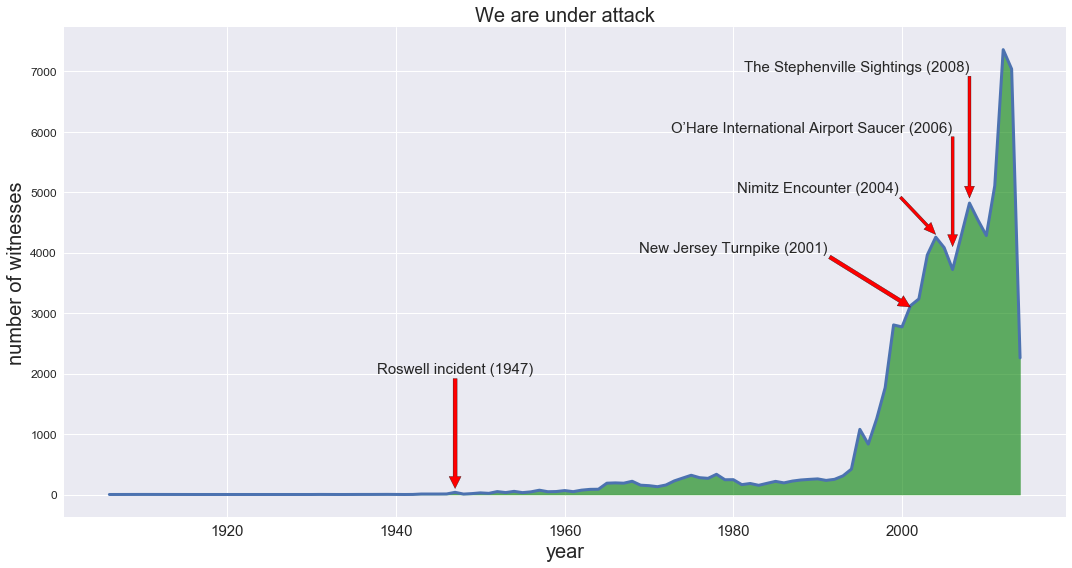

In [36]:
fig = plt.figure(figsize=(15, 8))
plt.plot(temp, lw=3)
plt.fill_between(temp.index, temp, color='green', alpha=0.6)

plt.annotate("Roswell incident (1947)", xy=(1947, 100), xytext=(1947, 2000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="red"))

plt.annotate("New Jersey Turnpike (2001)", xy=(2001, 3100), xytext=(1980, 4000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="red"))

plt.annotate("Nimitz Encounter (2004)", xy=(2004, 4300), xytext=(1990, 5000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="red", width=3, headwidth=10))

plt.annotate("O’Hare International Airport Saucer (2006)", xy=(2006, 4100), xytext=(2006, 6000), size=15,
             horizontalalignment='right',
             arrowprops=dict(facecolor="red", width=3, headwidth=10))
plt.annotate("The Stephenville Sightings (2008)", xy=(2008, 4900), xytext=(2008, 7000), size=15,
             horizontalalignment='right',
             arrowprops=dict(facecolor="red", width=3, headwidth=10))

plt.xlabel("year", fontsize=20)
plt.ylabel("number of witnesses", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.title("We are under attack", fontsize=20)

#plt.show()
plt.savefig("1_ufo_witnesses_over_time.png", fmt="png")
plt.savefig("1_ufo_witnesses_over_time.jpg", fmt="jpg")

## How X-files TV show and movies starring aliens influence the number of UFO witnesses

the idea of annotating movies is stolen from cool notebook of  :

C:\Anaconda\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


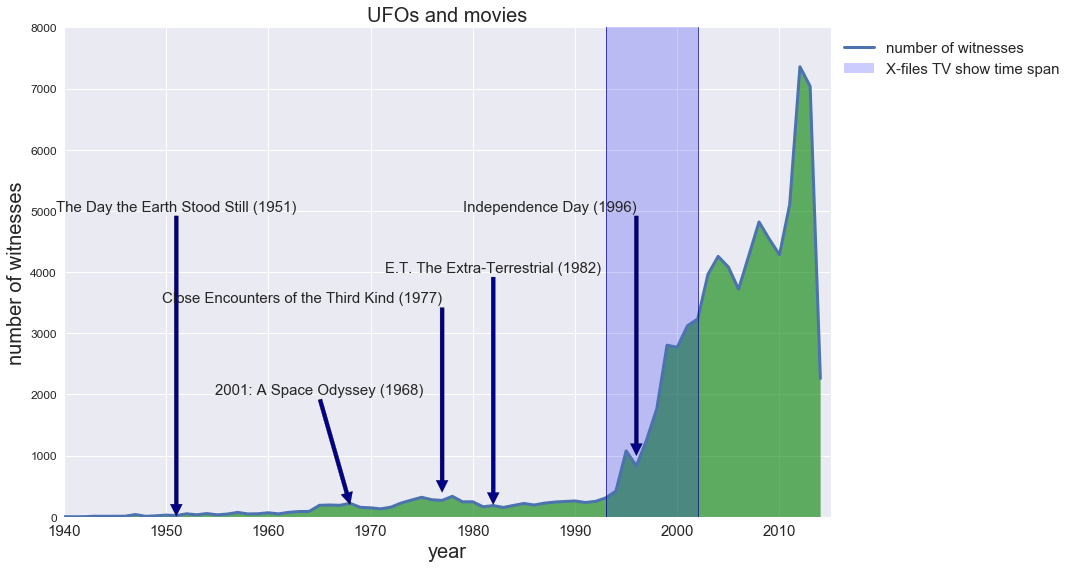

In [38]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
fig = plt.figure(figsize=(15, 8))
plt.plot(temp, lw=3, label="number of witnesses")
plt.fill_between(temp.index, temp, color='green', alpha=0.6)

plt.axvline(1993, lw=1, color="darkblue", alpha=0.7) 
plt.axvline(2002, lw=1, color="darkblue", alpha=0.7)

x = [1993, 1993, 2002, 2002]
y = [0, 8000, 8000, 0]

plt.fill(x, y, 'b', alpha=0.2, label='X-files TV show time span')

plt.annotate("""E.T. The Extra-Terrestrial (1982)""", xy=(1982, 200), xytext=(1982, 4000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="darkblue"))

plt.annotate("Independence Day (1996)", xy=(1996, 1000), xytext=(1996, 5000), size=15,
             horizontalalignment='right',
             arrowprops=dict(facecolor="darkblue"))

plt.annotate("The Day the Earth Stood Still (1951)", xy=(1951, 10), xytext=(1951, 5000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="darkblue"))

plt.annotate("Close Encounters of the Third Kind (1977)", xy=(1977, 400), xytext=(1977, 3500), size=15,
             horizontalalignment='right',
             arrowprops=dict(facecolor="darkblue"))

plt.annotate("2001: A Space Odyssey (1968)", xy=(1968, 200), xytext=(1965, 2000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="darkblue"))
     
plt.legend(bbox_to_anchor=(1.0, 1.0), prop={'size': 15})
plt.xlabel("year", fontsize=20)
plt.ylabel("number of witnesses", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.title("UFOs and movies", fontsize=20)
plt.ylim(0, 8000)
plt.xlim(1940, 2015)
#plt.show()
plt.savefig("1_ufo_witnesses_over_time_movies.png", fmt="png")
plt.savefig("1_ufo_witnesses_over_time_movies.jpg", fmt="jpg")

## UFO are of various shapes

In [40]:
temp = ufo['shape'].value_counts().sort_values(ascending=False)

C:\Anaconda\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


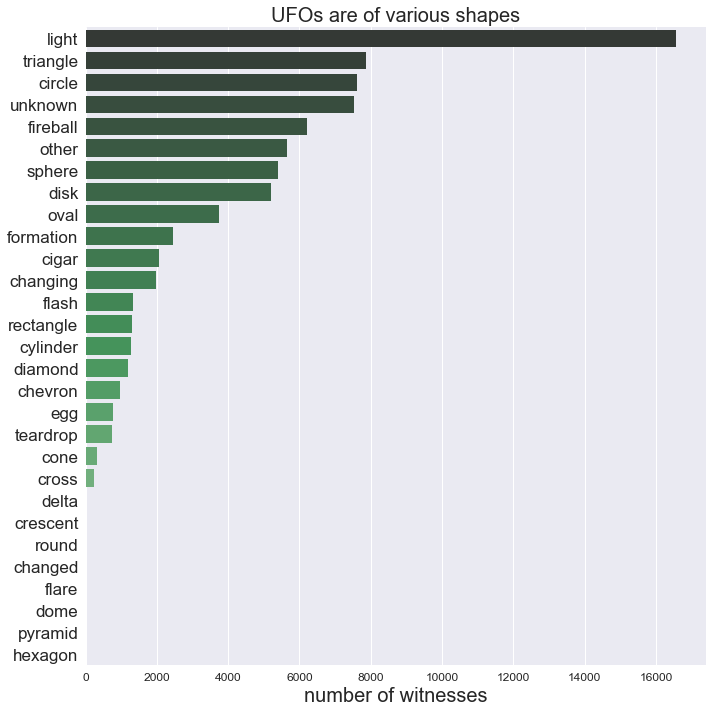

In [41]:
plt.figure(figsize=(10,10))
sns.barplot(temp, temp.index, palette="Greens_d")
plt.yticks(fontsize=17)
plt.xticks(fontsize=12)
plt.xlabel("number of witnesses", fontsize=20)
plt.title("UFOs are of various shapes", fontsize=20)
#plt.show()
plt.savefig("2_UFOs_are_of_various_shapes.png", fmt="png")
plt.savefig("2_UFOs_are_of_various_shapes.jpg", fmt="jpg")

## Shapes over years. "Rise of Unknowns" and "Light Prevalence" phenomena

Here we plot the shapes upon the time scale.

You can clearly observe the pike in the unknown shape. Let's call it: "The Rise of Unknowns". Further studies are needed to investigate this phenomenon. Perhaps, we just don't have enough data, or UFO's were so careful, so that people couldn't grasp their shape.


The second investigation is the prevalence of the light. Which is an issue as well

In [29]:
shape_year = ufo[['shape', 'year']]

In [30]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [31]:
data = []

for ufo_shape in temp.index[:]:
    df = pd.DataFrame(shape_year.loc[ufo['shape'] == ufo_shape, 'year'])
    shape = df['year'].value_counts()
    shape.sort_index(ascending=True, inplace=True)
    trace = go.Scatter(x=shape.index, y=shape, mode="lines", name=ufo_shape)
    data.append(trace)
    
iplot(data)



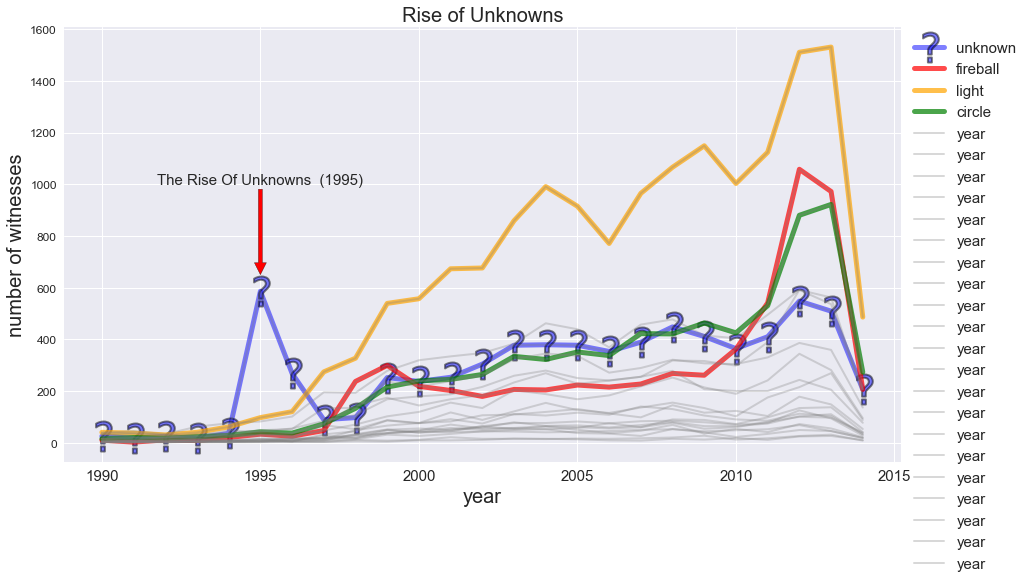

In [32]:
plt.figure(figsize=(15, 8))

unk = pd.DataFrame(shape_year.loc[ufo['shape'] == 'unknown', 'year'])
unk = unk['year'].value_counts()
unk.sort_index(ascending=True, inplace=True)   
plt.plot(unk.loc[1990:], label='unknown', lw=5, alpha=0.5, c='blue', marker='$?$', ms="30", markeredgewidth=2, 
        markeredgecolor='black')

fire = pd.DataFrame(shape_year.loc[ufo['shape'] == 'fireball', 'year'])
fire = fire['year'].value_counts()
fire.sort_index(ascending=True, inplace=True)   
plt.plot(fire.loc[1990:], label='fireball', lw=5, alpha=0.7, c='red')

light = pd.DataFrame(shape_year.loc[ufo['shape'] == 'light', 'year'])
light = light['year'].value_counts()
light.sort_index(ascending=True, inplace=True)   
plt.plot(light.loc[1990:], label='light', lw=5, alpha=0.7, c='orange')

circle = pd.DataFrame(shape_year.loc[ufo['shape'] == 'circle', 'year'])
circle = circle['year'].value_counts()
circle.sort_index(ascending=True, inplace=True)   
plt.plot(circle.loc[1990:], label='circle', lw=5, alpha=0.7, c='green')

for ufo_shape in temp.index[:21]:
    df = pd.DataFrame(shape_year.loc[ufo['shape'] == ufo_shape, 'year'])
    shape = df['year'].value_counts()
    shape.sort_index(ascending=True, inplace=True)
    plt.plot(shape.loc[1990:], lw=2, c='grey', alpha=0.3)

plt.annotate("The Rise Of Unknowns  (1995)", xy=(1995, 650), xytext=(1995, 1000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="red"))

plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize=15)
plt.xlabel("year", fontsize=20)
plt.ylabel("number of witnesses", fontsize=20)
plt.yticks(fontsize=12)
plt.xticks(fontsize=15)
plt.title("Rise of Unknowns", fontsize=20)
#plt.show()
plt.savefig("3_Rise_of_Unknowns.png", fmt="png")
plt.savefig("3_Rise_of_Unknowns.jpg", fmt="jpg")

## UFO tryies to land in the USA most often

In [33]:
temp = ufo['country'].value_counts()
temp.sort_values(inplace=True, ascending=False)

In [34]:
x_label = temp.index.values
y_data = temp.tolist()

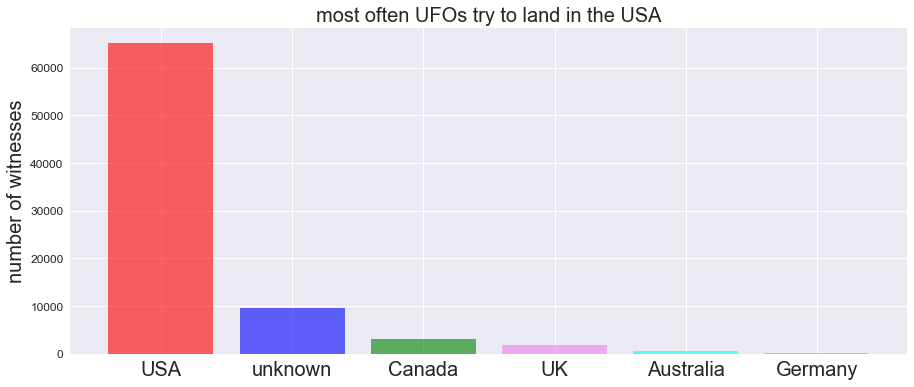

In [35]:
fig = plt.figure(figsize=(15, 6))
plt.bar(range(len(x_label)),  y_data, color=['red', 'blue', 'green', 'violet', 'cyan', 'darkgrey'], alpha=0.6)
plt.xticks(list(range(len(x_label))), ["USA", "unknown", "Canada", "UK", "Australia", "Germany"] , fontsize=20) #x_label
plt.yticks(fontsize=12) 
plt.ylabel('count', fontsize=25)
#plt.xlabel("country", fontsize=20)
plt.ylabel("number of witnesses", fontsize=20)
plt.title("most often UFOs try to land in the USA", fontsize=20)
#plt.show()
plt.savefig("4_most_often_UFOs_try_to_land_in_the_USA.png", fmt="png")
plt.savefig("4_most_often_UFOs_try_to_land_in_the_USA.jpg", fmt="jpg")

## UFO visit cities mostly in the USA

In [36]:
temp = ufo['city'].value_counts()
temp.sort_values(inplace=True, ascending=False)

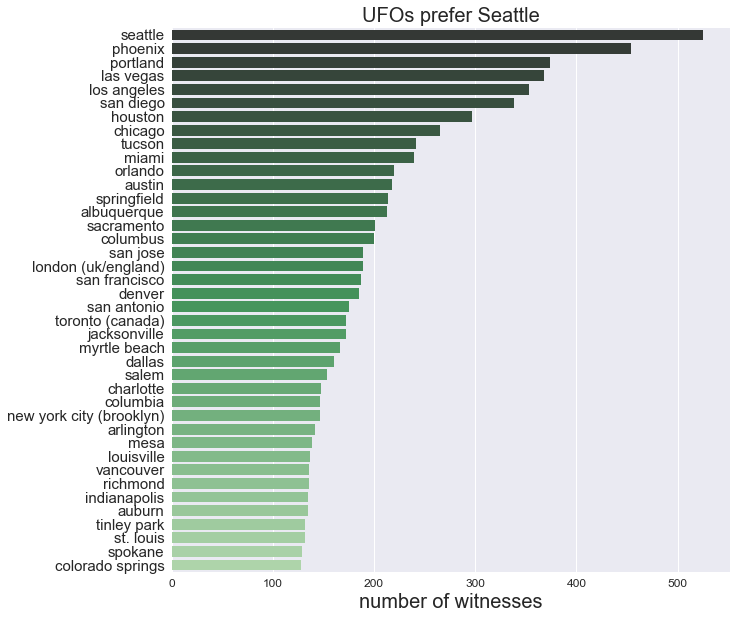

In [39]:
plt.figure(figsize=(10,10))
sns.barplot(temp[:40], temp.index[:40], palette="Greens_d")
plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
plt.title("UFOs prefer Seattle", fontsize=20)
plt.xlabel("number of witnesses", fontsize=20)
#plt.show()
plt.savefig("5_UFOs_love_Seattle.png", fmt="png")
plt.savefig("5_UFOs_love_Seattle.jpg", fmt="jpg")


## UFO prefers California most of all

In [40]:
f = open("./data/us_states_codes.txt")

In [41]:
d = {}
for line in f:
    d[line.split()[2].lower()] = line.split()[0]

ufo['state'] = ufo['state'].map(d)
f.close()

In [42]:
temp = ufo['state'].value_counts()
temp.sort_values(inplace=True, ascending=False)
x_label = temp.index.values
y_data = temp.tolist()

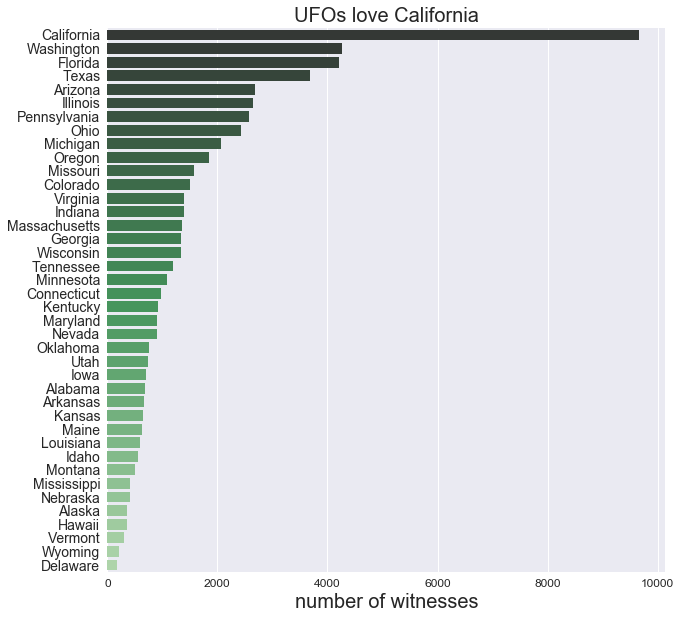

In [47]:
plt.figure(figsize=(10,10))
sns.barplot(temp, temp.index, palette="Greens_d")
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.title("UFOs love California", fontsize=20)
plt.xlabel("number of witnesses", fontsize=20)
#plt.show()
plt.savefig("6_UFOs_love_California.png", fmt="png")
plt.savefig("6_UFOs_love_California.jpg", fmt="jpg")

## UFOs give a chance to be observed for about 1 minute.

- this feature is rather skewed : we have many witnesses which observed UFO for about more than 24 hours
- dropping these outliers, we get rather nice distribution
- most people say round values of observing UFOs. Look at the 5, 10, 15, 20, 25, 30 values


C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



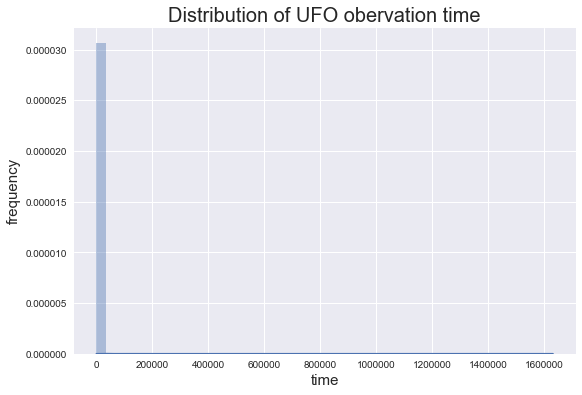

In [48]:
plt.figure(figsize=(9, 6))
sns.distplot(ufo['duration_min'])

plt.title("Distribution of UFO obervation time", fontsize=20)
plt.xlabel("time", fontsize=15)
plt.ylabel("frequency", fontsize=15)
plt.show()

In [49]:
ufo['duration_min'].mean()

150.28148360574346

In [50]:
ufo['duration_min'].std()

10336.946504858231

In [51]:
ufo['duration_min'].min()

1.6666666666666667e-05

In [52]:
ufo['duration_min'].max() / 60

27176.666666666668

**qqplot shows this skew the best : **

In [53]:
temp = ufo['duration_min']

In [54]:
temp = temp.sort_values()

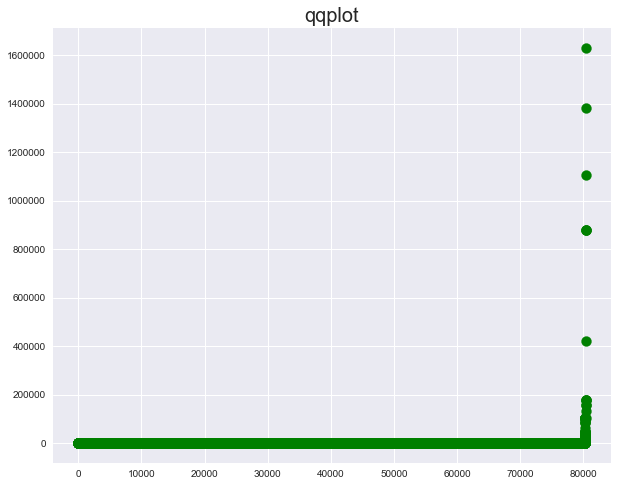

In [55]:
plt.figure(figsize=(10, 8))
plt.scatter(range(1, len(temp) + 1), temp.values, s=100, color="green")
plt.title("qqplot", fontsize=20)
plt.show()

**let's drop the outliers and plot distribution again : **

In [56]:
q = ufo["duration_min"].quantile(0.95)

In [57]:
temp = temp[temp < q]

C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



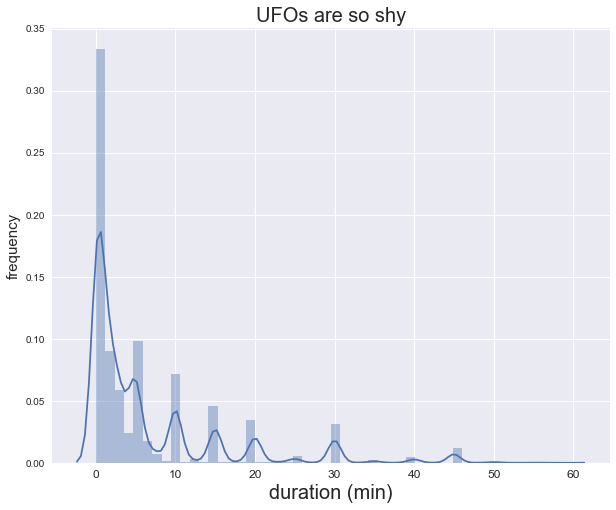

In [62]:
plt.figure(figsize=(10, 8))
sns.distplot(temp)
plt.xlabel('duration (min)', fontsize=20)
plt.ylabel("frequency", fontsize=15)
plt.xticks(fontsize=12)
plt.title("UFOs are so shy", fontsize=20)

#plt.show()
plt.savefig("7_UFOs_are_so_shy.png", fmt="png")
plt.savefig("7_UFOs_are_so_shy.jpg", fmt="jpg")

In [63]:
ufo.columns

Index(['datetime', 'city', 'state', 'country', 'shape', 'comments',
       'longitude', 'latitude', 'longitude ', 'duration_sec', 'longitude',
       'duration_min', 'year'],
      dtype='object')

# Comments analysis
People comment their UFO observation. We'll create word cloud using the text data from the the `commments` column

In [70]:
ufo['comments'] = ufo['comments'].astype(str)

In [71]:
text = ' '.join(ufo['comments'])

In [72]:
import re

**we remove 'thrash' symbols from the text :**

In [73]:
text = re.sub('[!@#&44]', '', text)
text = text.replace('Note', '')
text = text.replace('quot', '')

In [74]:
from wordcloud import WordCloud
import numpy as np
from PIL import Image

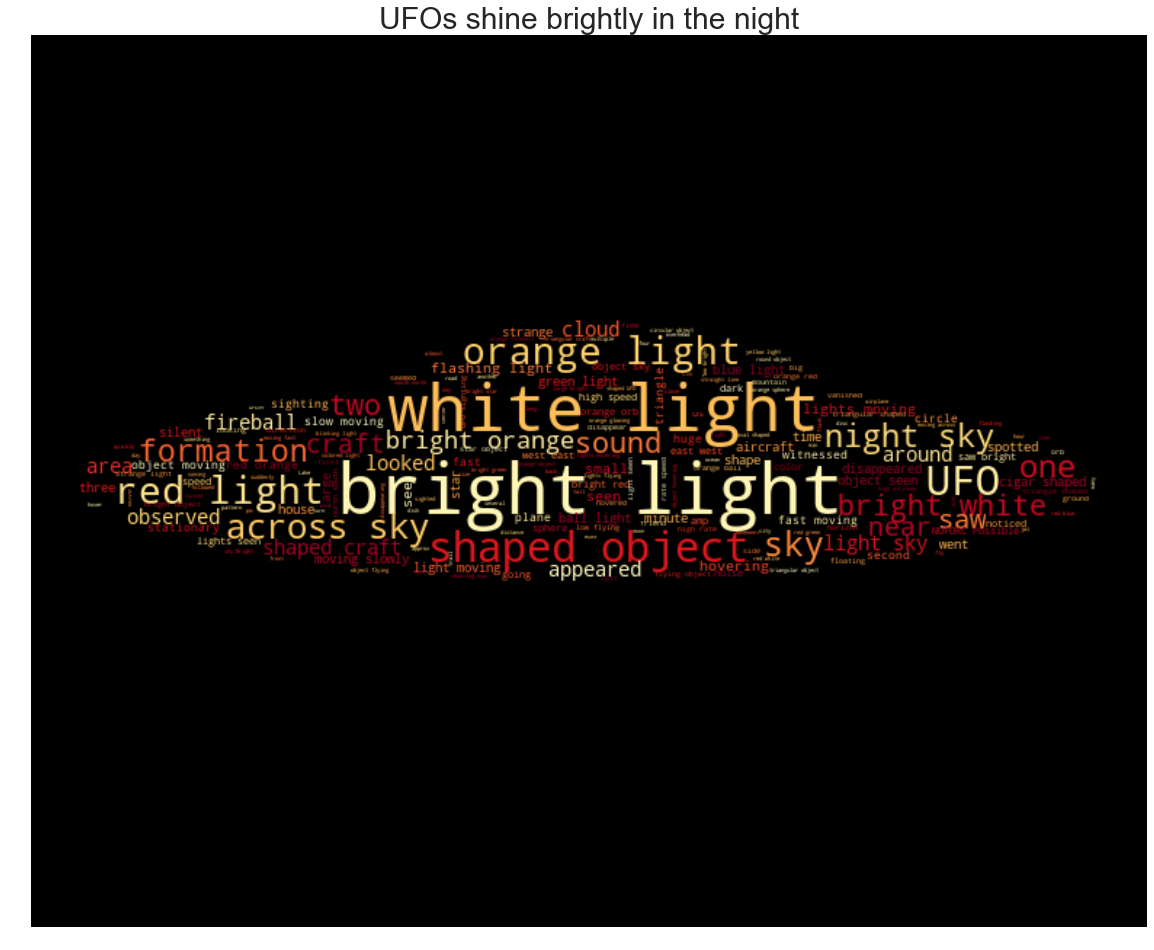

In [79]:
# Create the wordcloud object
wave_mask = np.array(Image.open("./data/ufo_craft.jpg"))

#wordcloud = WordCloud(width=480, height=480, margin=0, mask=wave_mask, background_color='skyblue', 
#colormap='Greens').generate(text)
wordcloud = WordCloud(width=480, height=480, margin=0, mask=wave_mask, colormap="YlOrRd").generate(text)

plt.figure(figsize=(20,20))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

plt.title("UFOs shine brightly in the night", fontsize=30)

#plt.show()
plt.savefig("8_UFOs_shine_brightly.png", fmt="png")
plt.savefig("8_UFOs_shine_brightly.jpg", fmt="jpg")

## UFO likes summer and prefers to stay in the shadow

In [100]:
ufo['month'] = ufo['datetime'].dt.month.astype(int)
ufo['day'] = ufo['datetime'].dt.day.astype(int)
ufo['day of the week'] = ufo['datetime'].dt.dayofweek.astype(int)
ufo['hour'] = ufo['datetime'].dt.hour.astype(int)
ufo['day of year'] = ufo['datetime'].dt.strftime('%m-%d')

In [101]:
temp = ufo['day of the week'].value_counts()
temp.sort_index(inplace=True)

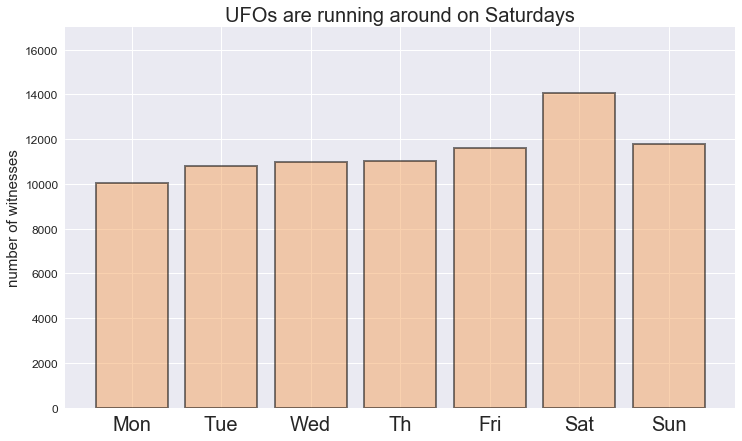

In [106]:
day_of_week = ["Mon", "Tue", "Wed", "Th", "Fri", "Sat", "Sun"]

plt.figure(figsize=(12, 7))
plt.bar(temp.index, temp, color="sandybrown", alpha=0.5, edgecolor="black", lw=2)
plt.xticks([0, 1, 2, 3, 4, 5, 6], day_of_week, fontsize=20)
plt.yticks(fontsize=12)
plt.title("UFOs are running around on Saturdays", fontsize=20)
plt.ylabel("number of witnesses", fontsize=15)
plt.ylim(0, 17000)
#plt.show()
plt.savefig("9_UFOs_are_runngin_around_on_saturdays.png", fmt="png")
plt.savefig("9_UFOs_are_runngin_around_on_saturdays.jpg", fmt="jpg")

In [86]:
temp = ufo['month'].value_counts()
temp.sort_index(inplace=True, ascending=False)

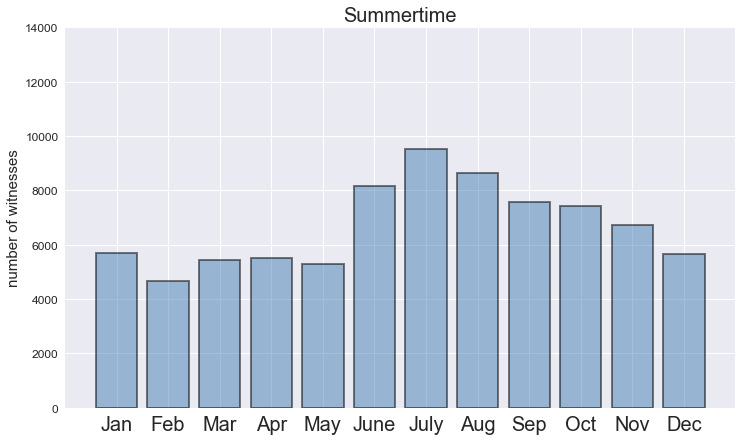

In [89]:
month = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]

plt.figure(figsize=(12, 7))
plt.bar(temp.index, temp, color="steelblue", alpha=0.5, edgecolor="black", lw=2)
plt.xticks(list(range(1, 13)), month, fontsize=20)
plt.yticks(fontsize=12)
plt.title("Summertime", fontsize=20)
plt.ylabel("number of witnesses", fontsize=15)
plt.ylim(0, 14000)
#plt.show()
plt.savefig("10_summertime.png", fmt="png")
plt.savefig("10_summertime.jpg", fmt="jpg")

In [108]:
temp = ufo['hour'].value_counts()
temp.sort_index(inplace=True)

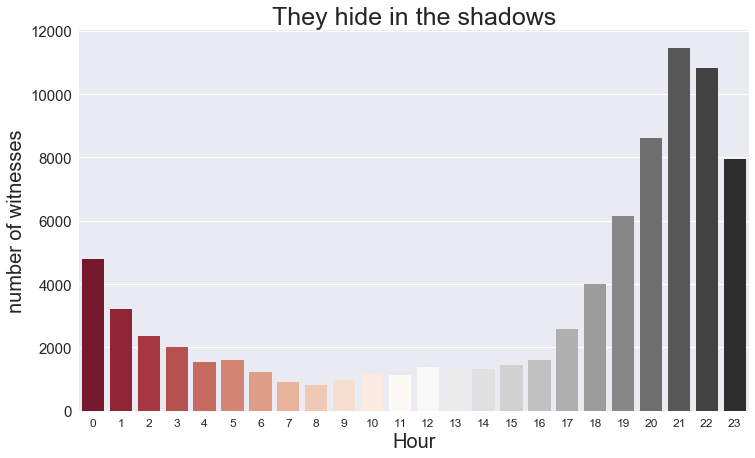

In [109]:
# TOFIX : background color to see the medium spectra
plt.figure(figsize=(12,7))
sns.barplot(temp.index, temp, palette="RdGy")
plt.xlabel("Hour", fontsize=20)
plt.ylabel("number of witnesses", fontsize=20)
plt.title("They hide in the shadows", fontsize=25)
plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
#plt.show()
plt.savefig("11_They_hide_in_the_shadows.png", fmt="png")
plt.savefig("11_They_hide_in_the_shadows.jpg", fmt="jpg")